# Links

This is a tool that helps users to write pipelines that depend on **abstractions** and not **concretions**.

To illustrate this, let's first create a couple of lookup tables that store metadata and define rowproperties for generating specific types (**concretions**) of images (blank and noisy)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from djutils import Schema, rowproperty

schema = Schema("djutils_tutorial_2")

@schema.lookup
class BlankImage:
    definition = """
    height  : int unsigned
    width   : int unsigned
    value   : tinyint unsigned
    """
    
    contents = [
        [36, 64, 0], [36, 64, 128], [36, 64, 255]
    ]
    
    @rowproperty
    def image(self):
        height, width, value = self.fetch1("height", "width", "value")
        return np.full([height, width], value, dtype=np.uint8)
    
    
@schema.lookup
class NoisyImage:
    definition = """
    height  : int unsigned
    width   : int unsigned
    seed    : int unsigned
    """
    
    contents = [
        [36, 64, 42], [36, 64, 101]
    ]
    
    @rowproperty
    def image(self):
        height, width, seed = self.fetch1("height", "width", "seed")
        rng = np.random.default_rng(seed)
        return rng.uniform(0, 255, size=[height, width]).round().astype(np.uint8)

Connecting ewang@at-database.ad.bcm.edu:3306


Let's take a look at the tables

In [2]:
BlankImage()

height,width,value
36,64,0
36,64,128
36,64,255


In [3]:
NoisyImage()

height,width,seed
36,64,42
36,64,101


And let's visualize their `image` rowproperties

--------Blank Images--------


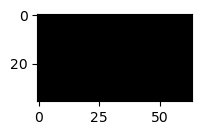

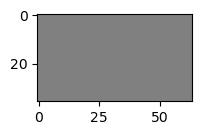

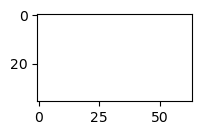

In [4]:
print("--------Blank Images--------")
for key in BlankImage:
    plt.figure(figsize=(2, 3))
    plt.imshow((BlankImage & key).image, vmin=0, vmax=255, cmap='gray')
    plt.show()

--------Noisy Images--------


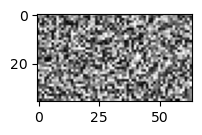

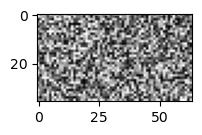

In [5]:
print("--------Noisy Images--------")
for key in NoisyImage:
    plt.figure(figsize=(2, 3))
    plt.imshow((NoisyImage & key).image, vmin=0, vmax=255, cmap='gray')
    plt.show()

How do we create a downstream table that depends on the **abstraction** of an image and not on the **concretion** of individual image types?

## Solution: Link tables via the `schema.link` decorator

In [6]:
@schema.link
class Image:
    links = [BlankImage, NoisyImage]
    name = "image"

The `schema.link` decorator creates an `Image` lookup table with the primary key `{name}_id` and secondary keys `{name}_type` and `{name}_ts`

In [7]:
Image()

image_id image,image_type image type,image_ts automatic timestamp


In addition, `Image.BlankImage` and `Image.NoisyImage` part tables are created, corresponding to the tables in the list of `links`

In [8]:
Image.BlankImage()

image_id image,height,width,value


In [9]:
Image.NoisyImage()

image_id image,height,width,seed


To get data from the upstream tables into the link lookup and part tables, use the `fill` method

In [10]:
Image.fill()

BlankImage -- Inserting 3 keys
NoisyImage -- Inserting 2 keys


This inserts 5 rows into `Image` ...

In [11]:
Image()

image_id image,image_type image type,image_ts automatic timestamp
5d842811721aa003f061a323f627c87a,NoisyImage,2023-07-06 22:23:01
989a9bbf8e533629cda8f1584259365a,NoisyImage,2023-07-06 22:23:01
ae8577c19dc5040d5c88da9d8639d8de,BlankImage,2023-07-06 22:23:01
ceb3e03469214e146500375d3b0062c8,BlankImage,2023-07-06 22:23:01
f4f66cfd04ff63ecceb64820559647f1,BlankImage,2023-07-06 22:23:01


... 3 of them belonging belonging to `BlankImage`

In [12]:
Image.BlankImage()

image_id image,height,width,value
ceb3e03469214e146500375d3b0062c8,36,64,0
f4f66cfd04ff63ecceb64820559647f1,36,64,128
ae8577c19dc5040d5c88da9d8639d8de,36,64,255


... and 2 of them belonging belonging to `NoisyImage`

In [13]:
Image.NoisyImage()

image_id image,height,width,seed
989a9bbf8e533629cda8f1584259365a,36,64,42
5d842811721aa003f061a323f627c87a,36,64,101


For any `row` of `Image`, `link` allows the user to access the upstream table

In [14]:
(Image & 'image_id like "5d842%"').link

height,width,seed
36,64,101


Using this link design, we can create pipelines that **depend on abstractions** and not concretions

In [15]:
@schema.computed
class ImageStats:
    definition = """
    -> Image
    ---
    mean  : float
    std   : float
    """
    
    def make(self, key):
        image = (Image & key).link.image
        key["mean"] = image.mean()
        key["std"] = image.std()
        self.insert1(key)

In [16]:
ImageStats.populate(display_progress=True)

100% 5/5 [00:00<00:00, 37.81it/s]


In [17]:
ImageStats()

image_id image,mean,std
5d842811721aa003f061a323f627c87a,127.059,73.6448
989a9bbf8e533629cda8f1584259365a,127.541,74.1578
ae8577c19dc5040d5c88da9d8639d8de,255.0,0.0
ceb3e03469214e146500375d3b0062c8,0.0,0.0
f4f66cfd04ff63ecceb64820559647f1,128.0,0.0


In [18]:
ImageStats * Image

image_id image,mean,std,image_type image type,image_ts automatic timestamp
5d842811721aa003f061a323f627c87a,127.059,73.6448,NoisyImage,2023-07-06 22:23:01
989a9bbf8e533629cda8f1584259365a,127.541,74.1578,NoisyImage,2023-07-06 22:23:01
ae8577c19dc5040d5c88da9d8639d8de,255.0,0.0,BlankImage,2023-07-06 22:23:01
ceb3e03469214e146500375d3b0062c8,0.0,0.0,BlankImage,2023-07-06 22:23:01
f4f66cfd04ff63ecceb64820559647f1,128.0,0.0,BlankImage,2023-07-06 22:23:01
